In [1]:
import os
import re
from dotenv import load_dotenv  
import psycopg2
import requests as rq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import linregress

In [2]:
# Import API key
load_dotenv('./.env')
nasa_key = os.getenv('nasa_key');

In [3]:
dates = ['2021-01-01', '2020-06-01', '2020-01-01', '2019-06-01', '2019-01-01']
responses = []

url = 'https://api.nasa.gov/neo/rest/v1/feed?'

for date in dates:
    params = {
        'start_date': date,
        'api_key': nasa_key
    }
    responses.append(rq.get(url, params=params))

In [4]:
asteroid_data = [resp.json()['near_earth_objects'] for resp in responses if resp.status_code == 200]
len(asteroid_data)

5

In [119]:
asteroid_specs = {
    'id': [],
    'day': [],
    'asteroid_name': [],
    'min_diam_m': [],
    'max_diam_m': [],
    'min_diam_f': [],
    'max_diam_f': [],
    'hazard_to_earth': []
}

asteroid_proximity_data = {
    'id':[],
    'approach_date': [],
    'velocity_kps': [],
    'velocity_kph': [],
    'velocity_mph': [],
    'miss_dist_km': [],
    'miss_dist_mi': []
}

for time_period in asteroid_data:
    for day in time_period:
        date = time_period[day]
        for i,_ in enumerate(date):
            diameter = date[i]['estimated_diameter']
            proximity = date[i]['close_approach_data'][0]

            asteroid_specs['day'].append(day)
            asteroid_specs['id'].append(date[i]['id'])
            asteroid_specs['asteroid_name'].append(date[i]['name'])
            asteroid_specs['max_diam_m'].append(diameter['meters']['estimated_diameter_max'])
            asteroid_specs['min_diam_m'].append(diameter['meters']['estimated_diameter_min'])
            asteroid_specs['max_diam_f'].append(diameter['feet']['estimated_diameter_max'])
            asteroid_specs['min_diam_f'].append(diameter['feet']['estimated_diameter_min'])
            asteroid_specs['hazard_to_earth'].append(date[i]['is_potentially_hazardous_asteroid'])

            asteroid_proximity_data['id'].append(date[i]['id'])
            asteroid_proximity_data['approach_date'].append(proximity['close_approach_date'])
            asteroid_proximity_data['velocity_kps'].append(proximity['relative_velocity']['kilometers_per_second'])
            asteroid_proximity_data['velocity_kph'].append(proximity['relative_velocity']['kilometers_per_hour'])
            asteroid_proximity_data['velocity_mph'].append(proximity['relative_velocity']['miles_per_hour'])
            asteroid_proximity_data['miss_dist_km'].append(proximity['miss_distance']['kilometers'])
            asteroid_proximity_data['miss_dist_mi'].append(proximity['miss_distance']['miles'])

In [121]:
proximity_df = pd.DataFrame(asteroid_proximity_data)
proximity_df[['velocity_kps', 'velocity_kph', 'velocity_mph', 'miss_dist_km', 'miss_dist_mi']] = proximity_df[['velocity_kps', 'velocity_kph', 'velocity_mph', 'miss_dist_km', 'miss_dist_mi']].astype(float)
proximity_df.head()

,id,approach_date,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi
0,3471590,2021-01-02,13.155437,47359.574574,29427.397879,3.781750e+07,2.349871e+07
1,3477945,2021-01-02,9.199820,33119.353743,20579.078441,3.564123e+07,2.214643e+07
2,3703247,2021-01-02,22.553298,81191.873402,50449.472670,5.291687e+07,3.288102e+07
3,3756788,2021-01-02,18.045971,64965.496106,40367.032844,5.639298e+07,3.504097e+07
4,3766183,2021-01-02,18.378334,66162.001234,41110.494600,7.159084e+07,4.448448e+07


In [122]:
proximity_df.describe()

,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi
count,560.000000,560.000000,560.000000,5.600000e+02,5.600000e+02
mean,12.663338,45588.017651,28326.621301,2.841305e+07,1.765505e+07
std,7.044682,25360.854728,15758.248872,2.270397e+07,1.410759e+07
min,1.689795,6083.263458,3779.903342,1.506528e+04,9.361133e+03
25%,7.354970,26477.892358,16452.332615,6.901983e+06,4.288694e+06
50%,11.327113,40777.607246,25337.619347,2.355347e+07,1.463545e+07
75%,16.531895,59514.821498,36980.195613,4.783691e+07,2.972448e+07
max,45.357152,163285.746391,101459.412806,7.457561e+07,4.633914e+07


In [123]:
asteroid_specs_df = pd.DataFrame(asteroid_specs)
asteroid_specs_df

,id,day,asteroid_name,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
0,3471590,2021-01-02,(2009 TK12),201.629919,450.858206,661.515505,1479.193637,True
1,3477945,2021-01-02,(2009 WN8),24.241248,54.205079,79.531656,177.838190,False
2,3703247,2021-01-02,(2014 YD42),96.506147,215.794305,316.621227,707.986587,False
3,3756788,2021-01-02,(2016 PN),221.082810,494.356193,725.337328,1621.903571,False
4,3766183,2021-01-02,(2016 YS8),139.493823,311.917671,457.656914,1023.351970,False
...,...,...,...,...,...,...,...,...
555,3836889,2019-01-01,(2018 XB4),42.126461,94.197631,138.210178,309.047354,False
556,3837538,2019-01-01,(2018 YV2),38.419789,85.909260,126.049181,281.854537,False
557,3837557,2019-01-01,(2019 AN),38.419789,85.909260,126.049181,281.854537,False
558,3837589,2019-01-01,(2019 AO2),38.419789,85.909260,126.049181,281.854537,False


In [124]:
asteroid_specs_df.describe()

,min_diam_m,max_diam_m,min_diam_f,max_diam_f
count,560.000000,560.000000,560.000000,560.000000
mean,101.321148,226.560973,332.418474,743.310304
std,196.174781,438.660145,643.618068,1439.173751
min,0.921627,2.060820,3.023709,6.761219
25%,17.561232,39.268108,57.615592,128.832380
50%,38.419789,85.909260,126.049181,281.854537
75%,116.025908,259.441818,380.662441,851.187094
max,2658.000000,5943.468684,8720.472720,19499.569798


In [125]:
size_day_df = asteroid_specs_df.groupby('day').mean()
size_day_df.head()

,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
day,,,,,
2019-01-01,79.099362,176.871551,259.512352,580.287261,0.111111
2019-01-02,112.419692,251.378073,368.831022,824.731238,0.000000
2019-01-03,79.319933,177.364763,260.236010,581.905408,0.090909
2019-01-04,66.743151,149.242223,218.973600,489.639854,0.058824
2019-01-05,137.890765,308.333124,452.397537,1011.591646,0.153846


In [126]:
size_asteroid_df = asteroid_specs_df.groupby('id').mean()
size_asteroid_df.head()

,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
id,,,,,
2004953,2658.000000,5943.468684,8720.472720,19499.569798,True
2018172,2016.299194,4508.582062,6615.155049,14791.936371,False
2065733,581.507040,1300.289270,1907.831556,4266.041049,False
2065909,384.197891,859.092601,1260.491809,2818.545370,True
2086450,608.912622,1361.570015,1997.744887,4467.093369,False


In [127]:
proximity_day_df = proximity_df.groupby('approach_date').mean()
proximity_day_df.head()

,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi
approach_date,,,,,
2019-01-01,10.167003,36601.210141,22742.568601,2.765980e+07,1.718700e+07
2019-01-02,16.920845,60915.040751,37850.237405,2.222126e+07,1.380765e+07
2019-01-03,13.146708,47328.148619,29407.871013,3.626608e+07,2.253469e+07
2019-01-04,11.658371,41970.136625,26078.610727,2.190941e+07,1.361387e+07
2019-01-05,10.438775,37579.591653,23350.496825,3.013947e+07,1.872780e+07


In [128]:
proximity_asteroid_df = proximity_df.groupby('id').mean()
proximity_asteroid_df.head()

,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi
id,,,,,
2004953,18.493943,66578.193056,41369.100013,5.913194e+07,3.674288e+07
2018172,8.759553,31534.391056,19594.244265,5.496324e+07,3.415257e+07
2065733,17.100178,61560.641961,38251.388890,1.799608e+07,1.118225e+07
2065909,11.742404,42272.654868,26266.583798,7.354857e+07,4.570096e+07
2086450,17.888427,64398.335463,40014.621277,2.582901e+07,1.604940e+07


In [129]:
# time v. size
# time v. velo (kph v. mph)
# velo v. hazard 
# size v. hazard
# mdk/mdm v. hazard
# mdk/mdm v. velo
# plots
# distrib?

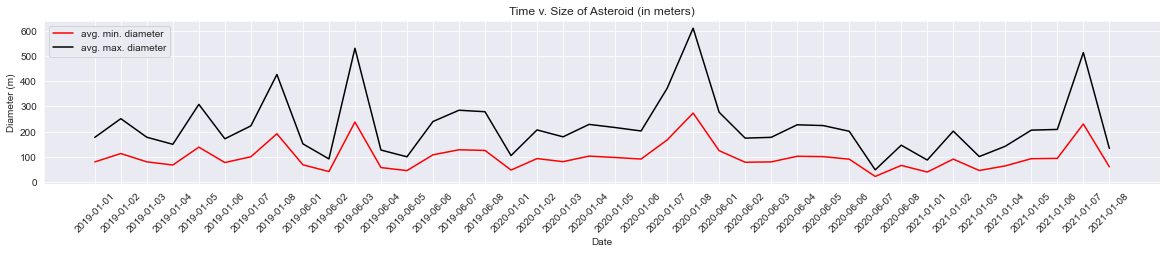

In [137]:
fig = plt.figure(figsize=(20, 3))
plt.plot(size_day_df.index, size_day_df.min_diam_m, color='red', label='avg. min. diameter')
plt.plot(size_day_df.index, size_day_df.max_diam_m, color='black', label='avg. max. diameter')

plt.title('Time v. Size of Asteroid (in meters)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Diameter (m)')
plt.legend();

plt.savefig('Resources/assets/images/time_size_m.png', dpi=400)

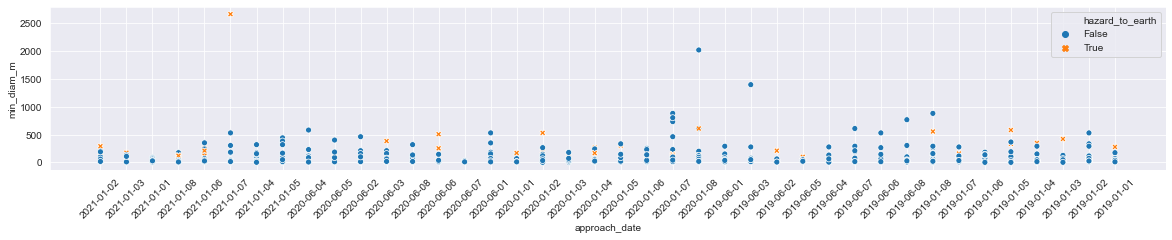

In [131]:
fig = plt.figure(figsize=(20, 3))
sns.set_style('darkgrid')
sns.scatterplot(x="approach_date", y="min_diam_m",
             hue="hazard_to_earth", style="hazard_to_earth",
             data=full_data)
plt.xticks(rotation=45)
plt.grid(True);

In [132]:
full_data = pd.merge(proximity_df, asteroid_specs_df, on='id', how='left')
full_data.head()

,id,approach_date,velocity_kps,velocity_kph,velocity_mph,miss_dist_km,miss_dist_mi,day,asteroid_name,min_diam_m,max_diam_m,min_diam_f,max_diam_f,hazard_to_earth
0,3471590,2021-01-02,13.155437,47359.574574,29427.397879,3.781750e+07,2.349871e+07,2021-01-02,(2009 TK12),201.629919,450.858206,661.515505,1479.193637,True
1,3477945,2021-01-02,9.199820,33119.353743,20579.078441,3.564123e+07,2.214643e+07,2021-01-02,(2009 WN8),24.241248,54.205079,79.531656,177.838190,False
2,3703247,2021-01-02,22.553298,81191.873402,50449.472670,5.291687e+07,3.288102e+07,2021-01-02,(2014 YD42),96.506147,215.794305,316.621227,707.986587,False
3,3756788,2021-01-02,18.045971,64965.496106,40367.032844,5.639298e+07,3.504097e+07,2021-01-02,(2016 PN),221.082810,494.356193,725.337328,1621.903571,False
4,3766183,2021-01-02,18.378334,66162.001234,41110.494600,7.159084e+07,4.448448e+07,2021-01-02,(2016 YS8),139.493823,311.917671,457.656914,1023.351970,False


In [133]:
import seaborn as sns

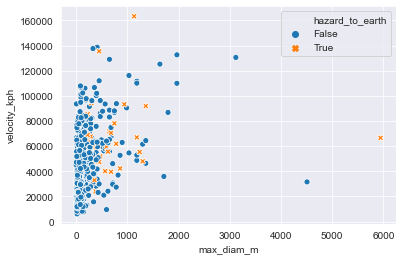

In [140]:
sns.set_style('darkgrid')
sns.scatterplot(data=full_data, 
                x="max_diam_m", y="velocity_kph", 
                hue="hazard_to_earth", style="hazard_to_earth")
plt.grid(True);

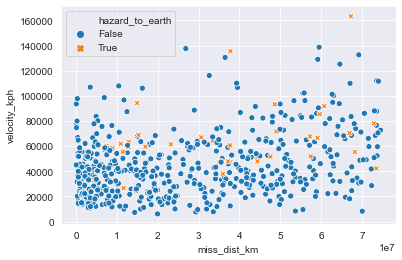

In [142]:
sns.set_style('darkgrid')
sns.scatterplot(data=full_data, 
                x="miss_dist_km", y="velocity_kph", 
                hue="hazard_to_earth", style="hazard_to_earth")
plt.grid(True);